     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 96.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.4/160.4 kB 10.3 MB/s eta 0:00:00
Using device: cpu
Using Colab cache for faster access to the 'smartphone-image-denoising-dataset' dataset.
Dataset path: /kaggle/input/smartphone-image-denoising-dataset
Noisy images found: 160
Clean images found: 160
Train samples: 128
Test samples: 32

Training started...

Epoch 1/5 | Loss: 0.0513
Epoch 2/5 | Loss: 0.0126
Epoch 3/5 | Loss: 0.0071
Epoch 4/5 | Loss: 0.0058
Epoch 5/5 | Loss: 0.0046

===== FINAL RESULTS =====
Average PSNR: 26.17286861295602
Average SSIM: 0.7595222


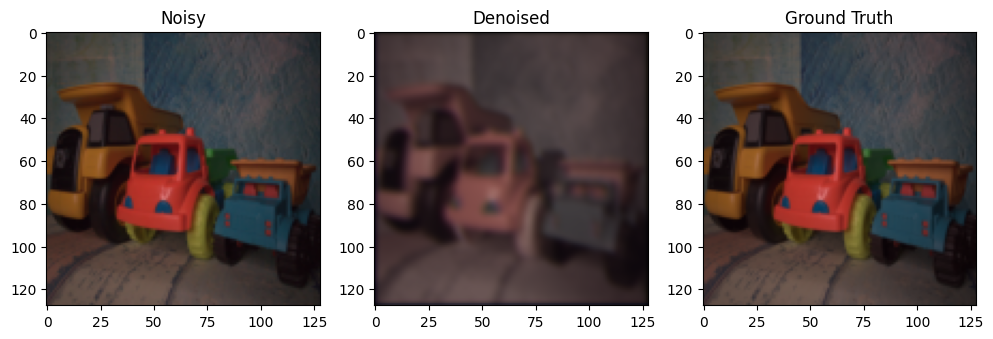

In [3]:
!pip -q install --upgrade kagglehub scikit-image
import kagglehub
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Download Dataset

path = kagglehub.dataset_download(
    "rajat95gupta/smartphone-image-denoising-dataset"
)
print("Dataset path:", path)

# FIND IMAGE PAIRS AUTOMATICALLY

noisy_images = []
clean_images = []
for root, _, files in os.walk(path):
    for file in files:
        name = file.lower()
        full_path = os.path.join(root, file)

        if "noisy" in name:
            noisy_images.append(full_path)

        elif "gt" in name or "clean" in name:
            clean_images.append(full_path)
print("Noisy images found:", len(noisy_images))
print("Clean images found:", len(clean_images))
noisy_images.sort()
clean_images.sort()
assert len(noisy_images) > 0 and len(clean_images) > 0, \
"Images not detected — dataset structure unexpected."

# DATASET CLASS

class DenoisingDataset(Dataset):
    def __init__(self, noisy_list, clean_list, transform=None):
        self.noisy = noisy_list
        self.clean = clean_list
        self.transform = transform

    def __len__(self):
        return min(len(self.noisy), len(self.clean))

    def __getitem__(self, idx):
        noisy = Image.open(self.noisy[idx]).convert("RGB")
        clean = Image.open(self.clean[idx]).convert("RGB")

        if self.transform:
            noisy = self.transform(noisy)
            clean = self.transform(clean)

        return noisy, clean

# TRANSFORMS

transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor()
])

dataset = DenoisingDataset(noisy_images, clean_images, transform)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, test_size]
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1)

print("Train samples:", train_size)
print("Test samples:", test_size)

# CNN MODEL

class DenoiseCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3,64,3,padding=1),
            nn.ReLU(),
            nn.Conv2d(64,64,3,padding=1),
            nn.ReLU(),
            nn.Conv2d(64,64,3,padding=1),
            nn.ReLU(),
            nn.Conv2d(64,3,3,padding=1)
        )

    def forward(self,x):
        return self.net(x)

model = DenoiseCNN().to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# TRAINING

epochs = 5
print("\nTraining started...\n")

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for noisy, clean in train_loader:
        noisy, clean = noisy.to(device), clean.to(device)

        optimizer.zero_grad()
        output = model(noisy)
        loss = criterion(output, clean)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs} | Loss: {total_loss/len(train_loader):.4f}")

# PSNR + SSIM

model.eval()

psnr_scores = []
ssim_scores = []

with torch.no_grad():
    for noisy, clean in test_loader:
        noisy = noisy.to(device)

        output = model(noisy).cpu().numpy()[0].transpose(1,2,0)
        clean = clean.numpy()[0].transpose(1,2,0)

        psnr_scores.append(
            peak_signal_noise_ratio(clean, output, data_range=1.0)
        )

        ssim_scores.append(
            structural_similarity(clean, output,
                                  channel_axis=2,
                                  data_range=1.0)
        )

print("\n===== FINAL RESULTS =====")
print("Average PSNR:", np.mean(psnr_scores))
print("Average SSIM:", np.mean(ssim_scores))

# VISUAL OUTPUT

noisy, clean = next(iter(test_loader))

with torch.no_grad():
    denoised = model(noisy.to(device)).cpu()

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.title("Noisy")
plt.imshow(noisy[0].permute(1,2,0))

plt.subplot(1,3,2)
plt.title("Denoised")
plt.imshow(denoised[0].permute(1,2,0))

plt.subplot(1,3,3)
plt.title("Ground Truth")
plt.imshow(clean[0].permute(1,2,0))

plt.show()